# Implementation of the Transformer architecture <a class="tocSkip">

Author: Samuel Nordmann

Here we propose a TensorFlow implementation from scratch of the Transformer as described in the original article [Vaswani et. al. Attention is all you need. Advances in Neural Information Processing Systems, 2017]. We give a detailed report on this article and define all the notations in an attached notebook. 

The details of the implementation follow the same line as  the one proposed by Andrew Ng in his Specialization course on Deep Learning.



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Sub-layers" data-toc-modified-id="Sub-layers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sub layers</a></span><ul class="toc-item"><li><span><a href="#Masking" data-toc-modified-id="Masking-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Masking</a></span><ul class="toc-item"><li><span><a href="#Padding-mask" data-toc-modified-id="Padding-mask-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Padding mask</a></span></li><li><span><a href="#Look-ahead-Mask" data-toc-modified-id="Look-ahead-Mask-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Look-ahead Mask</a></span></li></ul></li><li><span><a href="#Attention" data-toc-modified-id="Attention-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Attention</a></span><ul class="toc-item"><li><span><a href="#Single-head-attention" data-toc-modified-id="Single-head-attention-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Single head attention</a></span></li><li><span><a href="#MultiHead-Attention" data-toc-modified-id="MultiHead-Attention-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>MultiHead Attention</a></span></li></ul></li><li><span><a href="#Pointwise-FNN" data-toc-modified-id="Pointwise-FNN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Pointwise FNN</a></span></li><li><span><a href="#Positional-encoding" data-toc-modified-id="Positional-encoding-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Positional encoding</a></span></li></ul></li><li><span><a href="#Encoder" data-toc-modified-id="Encoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Encoder</a></span><ul class="toc-item"><li><span><a href="#Encoder-layer" data-toc-modified-id="Encoder-layer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Encoder layer</a></span></li><li><span><a href="#Full-Encoder" data-toc-modified-id="Full-Encoder-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Full Encoder</a></span></li></ul></li><li><span><a href="#Decoder" data-toc-modified-id="Decoder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decoder</a></span><ul class="toc-item"><li><span><a href="#Decoder-layer" data-toc-modified-id="Decoder-layer-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Decoder layer</a></span></li><li><span><a href="#Full-decoder" data-toc-modified-id="Full-decoder-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Full decoder</a></span></li></ul></li><li><span><a href="#Transformer" data-toc-modified-id="Transformer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transformer</a></span><ul class="toc-item"><li><span><a href="#Compilation-of-the-model" data-toc-modified-id="Compilation-of-the-model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Compilation of the model</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Learning-rate-scheduler" data-toc-modified-id="Learning-rate-scheduler-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Learning rate scheduler</a></span></li></ul></li></ul></div>

# Packages

In [99]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization, Conv1D, Reshape

print(tf.__version__)


2.7.0


# Sub layers

## Masking

There are two types of masks that are useful when building your Transformer network: the padding mask and the look-ahead mask. Both help the softmax computation give the appropriate weights to the words in the input sentence.

### Padding mask

When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model.

In the case where the sequence is padded with zeros, we need to create a mask to let the algorithm know that it should discard the zero values.

In [3]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix. n=batch_size, m=fixed size of input sentences
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, :] 

In [4]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


2022-02-05 23:42:35.182858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Look-ahead Mask

In training, we have access to the complete correct output of the training example. The look-ahead mask helps the model pretend that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.

In [5]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [6]:
x = tf.random.uniform((1, 3))
create_look_ahead_mask(x.shape[1])

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

## Attention

### Single head attention

In [7]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Calculate the attention weights.

    Arguments:
        Q -- query shape == (..., Tq, dk)
        K -- key shape == (..., Tv, dk)
        V -- value shape == (..., Tv, dv)
        mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

    Returns:
        output -- (attention,attention_weights)
    """
    
    #Compute the scaled dot-product Q•K
    matmul_QK = tf.matmul(Q,K,transpose_b=True)  # dot-product of shape (..., Tq, Tv)

    dk = K.shape[-1]
    scaled_attention_logits = matmul_QK/np.sqrt(dk) # scaled dot-product of shape (..., Tq, Tv)

    # Add the mask to the scaled dot-product
    if mask is not None: 
        scaled_attention_logits += (1. - mask) *(-1e9)

    # Compute the Softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # weights of shape (..., Tq, Tv)

    #Multiply with V
    output = tf.matmul(attention_weights,V)  # Attention representation of shape (..., Tq, dv)
    
    return output, attention_weights

In [9]:
## DEBUG

#Withtout masking
batch_size,Tq, Tv, dk, dv= 8,7,9,32,64
Q= tf.random.uniform((batch_size,Tq, dk))
K= tf.random.uniform((batch_size,Tv, dk))
V= tf.random.uniform((batch_size,Tv, dv))

A,_=scaled_dot_product_attention(Q, K, V)
print(A.shape)

#With masking. Needs Tq=Tv
batch_size,Tq, Tv, dk, dv= 16,9,9,64,128
Q= tf.random.uniform((batch_size,Tq, dk))
K= tf.random.uniform((batch_size,Tv, dk))
V= tf.random.uniform((batch_size,Tv, dv))
mask=create_look_ahead_mask(Tq)

A,_=scaled_dot_product_attention(Q, K, V)
print(A.shape)


(8, 7, 64)
(16, 9, 128)


### MultiHead Attention

In [10]:
class Multihead_Attention(tf.keras.layers.Layer):
    def __init__(self, H, d_model, dk, dv):
        
        """
        Arguments:
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        """
    
        super(Multihead_Attention, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.WQ = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WK = tf.Variable(initializer(shape=(H, d_model, dk)), trainable=True)
        self.WV = tf.Variable(initializer(shape=(H, d_model, dv)), trainable=True)
        self.WO = tf.Variable(initializer(shape=(H*dv,d_model)), trainable=True)

    
    def call(self, Q, K, V, mask=None):
        """
        Calculate the attention weights.

        Arguments:
            Q -- query shape == (..., Tq, d_model)
            K -- key shape == (..., Tv, d_model)
            V -- value shape == (..., Tv, d_model)
            mask: Float tensor with shape broadcastable to (..., Tq, Tv). Defaults to None.

        Returns:
            output -- Multihead attention A of shape (batch_size, Tq, d_model)
        """
        #Projecting Q,K,V to Qh, Kh, Vh. The H projection are stacked on the penultiem axis
        Qh= tf.experimental.numpy.dot(Q, self.WQ) #of shape (batch_size, Tq, H, dk)
        Kh= tf.experimental.numpy.dot(K, self.WK) #of shape (batch_size, Tv, H, dk)
        Vh= tf.experimental.numpy.dot(V, self.WV) #of shape (batch_size, Tv, H, dv)
        
        #Transposition
        Qh=tf.transpose(Qh, [0,2,1,3]) #of shape (batch_size, H, Tq, dk)
        Kh=tf.transpose(Kh, [0,2,1,3]) #of shape (batch_size, H, Tv, dk)
        Vh=tf.transpose(Vh, [0,2,1,3]) #of shape (batch_size, H, Tv, dv)
        
        # Computing the dot-product attention
        Ah,_=scaled_dot_product_attention(Qh, Kh, Vh, mask=mask) #of shape (batch_size, H, Tq, dv)
        
        #Flattening the H and dv axis and projecting back to d_model
#        A = tf.reshape(Ah,(*Ah.shape[:-2],-1))
        s=Ah.shape
        A = tf.reshape(Ah,(s[0],s[2],s[1]*s[3])) #of shape (batch_size, Tq, H*dv)
        A= tf.experimental.numpy.dot(A, self.WO) #of shape (batch_size, Tq, d_model)
        
        return A

In [11]:
## DEBUG

H, d_model, dk, dv=8,512,64,32
batch_size, Tq, Tv = 16,9,9

mha_layer= Multihead_Attention(H, d_model, dk, dv)

Q= tf.random.uniform((batch_size, Tq, d_model))
K= tf.random.uniform((batch_size, Tv, d_model))
V= tf.random.uniform((batch_size, Tv, d_model))
mask=create_look_ahead_mask(Tq)

A=mha_layer(Q,K,V)
print(A.shape)

(16, 9, 512)


## Pointwise FNN

In [12]:
class FNNLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        
        """
        Arguments:
        d_model -- the dimension of the embedding (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        """
            
        super(FNNLayer, self).__init__()

        self.layer1 = Conv1D(filters=dff, kernel_size=1,activation="relu")
        self.layer2 = Conv1D(filters=d_model, kernel_size=1)


    def call(self, x):
        """
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            
        Returns:
            fnn_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        
        x=self.layer1(x)
        fnn_layer_out=self.layer2(x)

        
        return fnn_layer_out

In [13]:
## DEBUG

d_model, dff = 64, 2048
fnn_layer= FNNLayer(d_model, dff)

batch_size, Tv= 16, 9
x=tf.random.uniform((batch_size, Tv, d_model))

print(fnn_layer(x).shape)



(16, 9, 64)


## Positional encoding

In [14]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size d_model
    
        arguments de get_angles:
            pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
            k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
            d(integer) -- Encoding size
            
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    pos=np.arange(positions)[:, np.newaxis] #Column vector containing the position span [0,1,..., positions]
    k= np.arange(d)[np.newaxis, :]  #Row vector containing the dimension span [[0, 1, ..., d-1]]
    i = k//2
    angle_rads = pos/(10000**(2*i/d)) #Matrix of angles indexed by (pos,i)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    #adds batch axis
    pos_encoding = angle_rads[np.newaxis, ...] 
    
    return tf.cast(pos_encoding, dtype=tf.float32)

Let us plot the obtained results

(1, 50, 512)


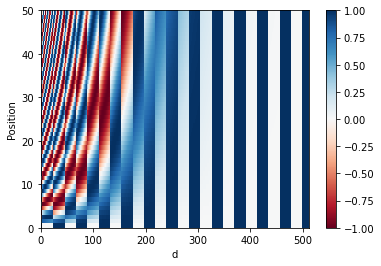

In [15]:
positions, d=50,512
pos_encoding = positional_encoding(positions, d)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Encoder

## Encoder layer

We recall that the encoder layer is composed by a multi-head self-attention mechanism, followed by a positionwise fully connected feed-forward network. This archirecture includes a residual connection around each of the two sub-layers, followed by layer normalization.

In [78]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(EncoderLayer, self).__init__()
        
        self.mha = Multihead_Attention(H, d_model, dk, dv)
        self.ffn = FNNLayer(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout_mha = Dropout(dropout_rate)
        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training=False, mask=None):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tq, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input. Defaults to None
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        A = self.mha(x,x,x,mask=mask) # Self attention (batch_size, Tq, d_model)
        A = self.dropout_mha(A, training=training) #Apply Dropout during training
        
        
        #  Residual connection + Layer normalization
        out1 = self.layernorm1(x+A)  # (batch_size, Tq, d_model)

        # Pointwise ffn
        ffn_output = self.ffn(out1) # (batch_size, Tq, d_model)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Apply Dropout during training
        
        # Residual connection + Layer normalization
        encoder_layer_out = self.layernorm2(ffn_output+out1)  # (batch_size, input_seq_len, fully_connected_dim)
        
        return encoder_layer_out

In [37]:
## DEBUG

H, d_model, dk, dv, dff = 8, 512, 64, 32, 2048
layer = EncoderLayer(H, d_model, dk, dv, dff)

batch_size, Tq= 43, 27
x = tf.random.uniform((batch_size, Tq, d_model))

output = layer(x,training=True)
print(output.shape)

(43, 27, 512)


## Full Encoder

In [79]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self, N, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        """
        Arguments:
        
        N -- number of stackeds Encoder layers (=6 in the paper)
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(Encoder, self).__init__()
        
        self.layers=[EncoderLayer(H, d_model, dk, dv, dff, 
                                  dropout_rate=dropout_rate, 
                                  layernorm_eps=layernorm_eps)
                                  for i in range(N)]
    
    def call(self, x, training=False, mask=None):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, Tq, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input. Defaults to None
        Returns:
            encoder_out -- Tensor of shape (batch_size, Tq, d_model)
        """
                                  
        for layer in self.layers:
            x = layer(x, training=training, mask=mask)
                                  
        return x
                                  

In [39]:
## DEBUG

N,H, d_model, dk, dv, dff = 6,8, 512, 64, 32, 2048
encoder = Encoder(N,H, d_model, dk, dv, dff)

batch_size, Tq= 43, 27
x = tf.random.uniform((batch_size, Tq, d_model))

output = encoder(x,training=True)
print(output.shape)

(43, 27, 512)


# Decoder

## Decoder layer

In [80]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(DecoderLayer, self).__init__()
        
        self.mha1 = Multihead_Attention(H, d_model, dk, dv)
        self.mha2 = Multihead_Attention(H, d_model, dk, dv)
        self.ffn = FNNLayer(d_model, dff)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout_mha1 = Dropout(dropout_rate)
        self.dropout_mha2 = Dropout(dropout_rate)                                     
        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, encoder_output, training=False, look_ahead_mask=None, padding_mask=None):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tv, d_model)
            encoder_output --  Tensor of shape (batch_size, Tv, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            look_ahead_mask -- Boolean mask for the target_input. Defaults to None
            padding_mask -- Boolean mask for the second multihead attention layer. Defaults to None
        Returns:
            decoder_layer_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        # 1st Masked MultiHead attention                                     
        A1 = self.mha1(x,x,x,mask=look_ahead_mask) # Self attention (batch_size, Tq, d_model)
        A1 = self.dropout_mha1(A1, training=training) #Apply Dropout during training
        
        #  Residual connection + Layer normalization
        out1 = self.layernorm1(x+A1)  # (batch_size, Tq, d_model)

        # 2nd Masked MultiHead attention                                     
        A2 = self.mha2(x,encoder_output,encoder_output,mask=padding_mask) # Self attention (batch_size, Tq, d_model)
        A2 = self.dropout_mha2(A2, training=training) #Apply Dropout during training
        
        
        #  Residual connection + Layer normalization
        out2 = self.layernorm2(out1+A2)  # (batch_size, Tq, d_model)
                                             
        # Pointwise ffn
        ffn_output = self.ffn(out2) # (batch_size, Tq, d_model)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Apply Dropout during training
        
        # Residual connection + Layer normalization
        decoder_layer_out = self.layernorm3(ffn_output+out2)  # (batch_size, input_seq_len, fully_connected_dim)
        
        return decoder_layer_out

In [73]:
## DEBUG

H, d_model, dk, dv, dff = 8, 512, 64, 32, 2048
layer = DecoderLayer(H, d_model, dk, dv, dff)

batch_size, Tq, Tv= 43, 57, 57
x = tf.random.uniform((batch_size, Tv, d_model))
encoder_output = tf.random.uniform((batch_size, Tq, d_model))

output = layer(x,encoder_output,training=True)
#print(output.shape)

## Full decoder

In [81]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, N, H, d_model, dk, dv, dff, dropout_rate=0.1, layernorm_eps=1e-6):
        
        """
        Arguments:

        N -- number of stackeds Decoder layers (=6 in the paper)
        H -- number of heads (=8 in the paper)
        d_models -- embedding dimension (=512 in the paper)
        dk -- depth of Q and K (=64 in the paper)
        dv -- depth of V (=64 in the paper)
        dff -- the dimension of the hidden layer of the FNN (=2048 in the paper)
        dropout_rate -- Dropout parameter used (during training) before all the residual connections
        layernorm_eps -- eta regularizing parameter for the Normalization layer 
        """
        
        super(Decoder, self).__init__()
        
        self.layers=[DecoderLayer(H, d_model, dk, dv, dff, 
                                  dropout_rate=dropout_rate, 
                                  layernorm_eps=layernorm_eps)
                                  for i in range(N)]
    
    def call(self, x, encoder_output, training=False, look_ahead_mask=None, padding_mask=None):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, Tv, d_model)
            encoder_output --  Tensor of shape (batch_size, Tv, d_model)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers. Defaults to False
            look_ahead_mask -- Boolean mask for the target_input. Defaults to None
            padding_mask -- Boolean mask for the second multihead attention layer. Defaults to None
        Returns:
            decoder_out -- Tensor of shape (batch_size, Tq, d_model)
        """
        
        for layer in self.layers:
            x = layer(x,encoder_output, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
                                  
        return x


In [45]:
## DEBUG

N,H, d_model, dk, dv, dff = 6,8, 512, 64, 32, 2048
decoder = Decoder(N,H, d_model, dk, dv, dff)

batch_size, Tq, Tv= 43, 57, 57
x = tf.random.uniform((batch_size, Tv, d_model))
encoder_output = tf.random.uniform((batch_size, Tq, d_model))

output = decoder(x,encoder_output,training=True)
print(output.shape)

(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)
(43, 57, 512)


# Transformer

In [91]:
class Transformer(tf.keras.Model):
    
    def __init__(self, N, H, d_model, dk, dv, dff, 
                 vocab_size, max_positional_encoding, 
                 dropout_rate=0.1, layernorm_eps=1e-6):

        super(Transformer, self).__init__()
        
        initializer = tf.keras.initializers.GlorotUniform()
        self.embedding = tf.Variable(initializer(shape=(vocab_size, d_model)), trainable=True)
        self.PE = positional_encoding(max_positional_encoding, d_model)
        
        self.dropout_encoding_input = Dropout(dropout_rate)
        self.dropout_decoding_input = Dropout(dropout_rate)
        
        self.encoder = Encoder(N, H, d_model, dk, dv, dff, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)
        self.decoder = Decoder(N, H, d_model, dk, dv, dff, dropout_rate=dropout_rate, layernorm_eps=layernorm_eps)

        

    def call(self, x, y, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        
        x = tf.matmul(x,self.embedding)
        x = x + self.PE
        x =  self.dropout_encoding_input(x,training=training)
        
        encoder_output = self.encoder(x,training=training, mask=enc_padding_mask)
        
        y = tf.matmul(y,self.embedding)
        y = y + self.PE
        y = self.dropout_decoding_input(y,training=training)
        
        dec_output = self.decoder(y, encoder_output, training=training, 
                                  look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        
        
        pred =  tf.matmul(embedding,dec_output,transpose_b=True)
        pred = tf.nn.softmax(pred)
        
        return pred
    
    

In [107]:
N, H, d_model, dk, dv, dff = 6, 8, 512, 64, 64, 2048
vocab_size, T =29, 11
batch_size = 3

transformer = Transformer(N, H, d_model, dk, dv, dff, 
                 vocab_size, max_positional_encoding)

input_shape = (None, T,vocab_size)


x = tf.random.uniform((batch_size, T, vocab_size))
y =  tf.random.uniform((batch_size, T, vocab_size))

pred = transformer(x,y,training=True)
print(pred.shape)

transformer.summary()

(3, 29, 11)
Model: "transformer_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_533 (Dropout)       multiple                  0         
                                                                 
 dropout_534 (Dropout)       multiple                  0         
                                                                 
 encoder_15 (Encoder)        multiple                  18902016  
                                                                 
 decoder_17 (Decoder)        multiple                  25199616  
                                                                 
Total params: 44,116,480
Trainable params: 44,116,480
Non-trainable params: 0
_________________________________________________________________


## Compilation of the model

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0, beta_1=0.9, beta_2=0.98, epsilon=1e-09)

transformer.compile(loss='crossentropy',optimizer=optimizer,metrics=['accuracy'])

# Training

## Learning rate scheduler

In [110]:
warmup_step = 4000
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def on_train_batch_start(self, i, batch_logs):
        transformer.optimizer.lr = dk**(-0.5)*min(i**(-0.5),warmup_step**(-3/2)*i)


callback = LearningRateScheduler()